In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [3]:
import warnings
import os
import sys

sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')


os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [8]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize
from scipy import stats

In [9]:
from metric_functions import get_metrics_classification, get_metrics_multiclass, 
check_overfitting_classification, check_overfitting_multiclass

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
!pip install optuna

In [12]:
import optuna

In [13]:
RAND = 42
N_FOLDS = 5

final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Сбор всех данных

In [14]:
id_to_submit = pd.read_parquet('submit.pqt')

In [15]:
targets = pd.read_parquet('public_train.pqt')

In [16]:
df = pd.read_csv('data_agg/df_final.csv')

In [17]:
df.head()

,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,4,199,10,0.336717,0.287648,0.358714,0.016920,20,38.850000,0.647632,0.4650,smartphone,Android,Huawei,12990.0,5,9,108
1,16,443,137,0.359870,0.260764,0.268075,0.111292,64,39.515625,1.397836,0.8647,smartphone,Android,Samsung,9583.0,1,1,50
2,18,566,34,0.503111,0.101333,0.365333,0.030222,32,60.937500,1.204972,0.8423,smartphone,Android,Samsung,22887.0,1,2,141
3,26,180,126,0.176817,0.400786,0.298625,0.123772,20,71.800000,0.688696,0.9090,smartphone,Android,Samsung,4990.0,1,1,126
4,27,808,342,0.302622,0.331461,0.237828,0.128090,67,66.074620,1.088583,0.9307,smartphone,Android,Xiaomi,12990.0,1,2,209


In [18]:
df = df.astype(final_types)
df.dtypes

user_id                     int32
part_of_day_day             int16
part_of_day_night           int16
day_pct                   float32
evening_pct               float32
morning_pct               float32
night_pct                 float32
act_days                    int16
avg_req_per_day           float32
requests_std              float32
act_days_pct              float32
cpe_type_cd              category
cpe_model_os_type        category
cpe_manufacturer_name    category
price                     float32
region_cnt                   int8
city_cnt                     int8
url_host_cnt                int16
dtype: object

In [19]:
df.shape

(415317, 18)

In [21]:
url_emb = pd.read_csv('embeddings/url_emb.csv')
url_emb = url_emb.add_suffix('_url').rename(columns={'user_id_url': 'user_id'})

In [22]:
reg_emb = pd.read_csv('embeddings/reg_emb.csv')
reg_emb = reg_emb.add_suffix('_reg').rename(columns={'user_id_reg': 'user_id'})

In [23]:
city_emb = pd.read_csv('embeddings/city_emb.csv')
city_emb = city_emb.add_suffix('_city').rename(
    columns={'user_id_city': 'user_id'})

In [24]:
model_emb = pd.read_csv('embeddings/model_emb.csv')
model_emb = model_emb.add_suffix('_model').rename(
    columns={'user_id_model': 'user_id'})

In [25]:
metrics_gender = pd.read_csv('metrics/metrics_gender_embeddings.csv')
metrics_age = pd.read_csv('metrics/metrics_age_embeddings.csv')

# Baseline gender prediction

In [26]:
df_train = targets.merge(df, how='inner', on=['user_id']) \
                  .merge(url_emb, how='inner', on='user_id') \
                  .merge(city_emb, how='inner', on=['user_id']) \
                  .merge(reg_emb, how='inner', on=['user_id']) \
                  .merge(model_emb, how='inner', on=['user_id'])

df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()
df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [27]:
%%time
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.52 s, sys: 438 ms, total: 1.96 s
Wall time: 1.96 s


## LGBM Optuna

In [28]:
# параметры, подобранные с помощью Optuna
# будем использовать эти модели в стекинге
lgbm_gender_best1 = {
    'n_estimators': 1600,
    'learning_rate': 0.04323025519185361,
    'num_leaves': 900,
    'max_depth': 7,
    'min_child_samples': 1200,
    'reg_alpha': 0,
    'reg_lambda': 9,
    'min_split_gain': 3,
    'subsample': 0.6909275901887844,
    'subsample_freq': 1,
    'colsample_bytree': 0.34716278523119637,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

lgbm_gender_params_2 = {
    'n_estimators': 2200,
    'learning_rate': 0.04667738692602193,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

lgbm_gender_params_3 = {
    'n_estimators': 2600,
    'learning_rate': 0.03825929958722602,
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [29]:
def objective_lgbm(trial, X, y, N_FOLDS, random_state):

    lgbm_params = {
        # "n_estimators": trial.suggest_categorical("n_estimators", [i for i in range(1200, 3501, 100)]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "n_estimators":
        trial.suggest_categorical("n_estimators", [1600]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.04323025519185361]),
        'num_leaves':
        trial.suggest_categorical("num_leaves", [900]),
        'max_depth':
        trial.suggest_categorical("max_depth", [7]),
        'min_child_samples':
        trial.suggest_categorical("min_child_samples", [1200]),
        'reg_alpha':
        trial.suggest_categorical("reg_alpha", [0]),
        'reg_lambda':
        trial.suggest_categorical("reg_lambda", [9]),
        'min_split_gain':
        trial.suggest_categorical("min_split_gain", [3]),
        'subsample':
        trial.suggest_categorical("subsample", [0.6909275901887844]),
        'subsample_freq':
        trial.suggest_categorical("subsample_freq", [1]),
        'colsample_bytree':
        trial.suggest_categorical("colsample_bytree", [0.34716278523119637]),

        # "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        # "max_depth": trial.suggest_int("max_depth", 3, 12),
        # "min_child_samples": trial.suggest_int("min_child_samples",
        #                                       100, 50000, step=100),
        # "reg_alpha": trial.suggest_int("reg_alpha", 0, 100),
        # "reg_lambda": trial.suggest_int("reg_lambda", 0, 100),
        # "min_split_gain": trial.suggest_int("min_split_gain", 0, 20),
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # "subsample_freq": trial.suggest_categorical("subsample_freq", [1]),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "scale_pos_weight":
        trial.suggest_categorical("scale_pos_weight", [ratio]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc")

        model = LGBMClassifier(**lgbm_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds_proba = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = m.roc_auc_score(y_test, preds_proba)

        return np.mean(cv_predicts)

In [30]:
study_lgbm = optuna.create_study(direction='maximize', study_name='LGBM_01')


def func(trial):
    return objective_lgbm(trial,
                          X_train,
                          y_train,
                          N_FOLDS=N_FOLDS,
                          random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(func, n_trials=1, show_progress_bar=True)

[I 2023-04-01 17:53:00,797] A new study created in memory with name: LGBM_01


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
study_lgbm.best_value

0.4692076722748436

In [32]:
study_lgbm.best_params

{'n_estimators': 1600,
 'learning_rate': 0.04323025519185361,
 'num_leaves': 900,
 'max_depth': 7,
 'min_child_samples': 1200,
 'reg_alpha': 0,
 'reg_lambda': 9,
 'min_split_gain': 3,
 'subsample': 0.6909275901887844,
 'subsample_freq': 1,
 'colsample_bytree': 0.34716278523119637,
 'scale_pos_weight': 0.9531740695036613,
 'random_state': 42}

In [33]:
%%time
lgbm_gender = LGBMClassifier(**study_lgbm.best_params)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train_,
                y_train_,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=0)

CPU times: user 4min 58s, sys: 1.76 s, total: 4min 59s
Wall time: 1min 25s


LGBMClassifier(colsample_bytree=0.34716278523119637,
               learning_rate=0.04323025519185361, max_depth=7,
               min_child_samples=1200, min_split_gain=3, n_estimators=1600,
               num_leaves=900, random_state=42, reg_alpha=0, reg_lambda=9,
               scale_pos_weight=0.9531740695036613,
               subsample=0.6909275901887844, subsample_freq=1)

In [34]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.694


In [35]:
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.898
ROC-AUC test = 0.847
delta = 6.03%


In [ ]:
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)
metrics_gender = metrics_gender[:9]

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='LGBM_Optuna_1'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_1,0.773999,0.754267,0.764006,0.847433,0.694865


### Holdout

In [46]:
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = LGBMClassifier(**lgbm_gender_best1)
    model.fit(X_train_, y_train_)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8472792859556377 

id = 1 0.8444936618814942 

id = 2 0.8466383049917041 

id = 3 0.8459967433561042 

id = 4 0.8465454982196126 

0.8461906988809105


In [43]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [44]:
print('ROC-AUC mean OOF: %.3f, std: %.3f' %
      (np.mean(cv_predicts_val), np.std(cv_predicts_val)))
print('ROC-AUC HOLDOUT: %.3f' % m.roc_auc_score(y_test, test_pred_proba[:, 1]))

ROC-AUC mean OOF: 0.846, std: 0.001
ROC-AUC HOLDOUT: 0.851


In [ ]:
metrics_gender = metrics_gender[:10]

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               test_pred,
                               test_pred_proba,
                               name='LGBM_Optuna_Holdout_1'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_1,0.773999,0.754267,0.764006,0.847433,0.694865
0,LGBM_Optuna_Holdout_1,0.776396,0.754193,0.765134,0.850502,0.701003


С помощью Optuna и кросс-валидации удалось улучшить метрики, в дальнейшем будем использовать эту модель для стейкинга

## CatBoost Optuna

In [45]:
cat_gender_best = {
    'iterations': 3000,
    'learning_rate': 0.051418504137325544,
    'max_depth': 4,
    'colsample_bylevel': 0.7594434568905333,
    'l2_leaf_reg': 57.13098420673366,
    'random_strength': 30.89358906898957,
    'bootstrap_type': 'No',
    'border_count': 128,
    'grow_policy': 'Lossguide',
    'od_wait': 1886,
    'leaf_estimation_iterations': 15,
    'eval_metric': 'AUC',
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [ ]:
from catboost import Pool


def objective_cat(trial, X, y, N_FOLDS, random_state):

    cat_params = {
        "iterations":
        trial.suggest_categorical("iterations", [3000]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.051418504137325544]),
        "max_depth":
        trial.suggest_int("max_depth", 4, 10),
        "colsample_bylevel":
        trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        "random_strength":
        trial.suggest_uniform('random_strength', 10, 50),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        "border_count":
        trial.suggest_categorical('border_count', [128, 254]),
        "grow_policy":
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", "Depthwise", "Lossguide"]),
        "od_wait":
        trial.suggest_int('od_wait', 500, 2000),
        "leaf_estimation_iterations":
        trial.suggest_int('leaf_estimation_iterations', 1, 15),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "eval_metric":
        trial.suggest_categorical("eval_metric", ['AUC']),
        "scale_pos_weight":
        trial.suggest_categorical("scale_pos_weight", [ratio]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample",
                                                      0.1,
                                                      1,
                                                      log=True)

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)

        model = CatBoostClassifier(**cat_params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds_proba = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = m.roc_auc_score(y_test, preds_proba)

        return np.mean(cv_predicts)

In [ ]:
%%time
study_cat = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_01")


def func(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


study_cat.optimize(func, n_trials=10, show_progress_bar=True)

In [ ]:
study_cat.best_value

0.696486982417721

In [ ]:
study_cat.best_params

{'iterations': 3000,
 'learning_rate': 0.051418504137325544,
 'max_depth': 4,
 'colsample_bylevel': 0.7594434568905333,
 'l2_leaf_reg': 57.13098420673366,
 'random_strength': 30.89358906898957,
 'bootstrap_type': 'No',
 'border_count': 128,
 'grow_policy': 'Lossguide',
 'od_wait': 1886,
 'leaf_estimation_iterations': 15,
 'use_best_model': True,
 'eval_metric': 'AUC',
 'scale_pos_weight': 0.9531740695036613,
 'random_state': 42}

In [ ]:
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 1h 10min 17s, sys: 50.8 s, total: 1h 11min 8s
Wall time: 20min 30s


In [ ]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.695


In [ ]:
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.907
ROC-AUC test = 0.848
delta = 7.07%


In [ ]:
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)
metrics_gender = metrics_gender[:9]

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoost_Optuna'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_1,0.773999,0.754267,0.764006,0.847433,0.694865
0,LGBM_Optuna_Holdout_1,0.776396,0.754193,0.765134,0.850502,0.701003
0,CatBoost_Optuna,0.772843,0.752826,0.762703,0.847530,0.695060


### Holdout

In [ ]:
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)

    model.fit(X_train_, y_train_, verbose=False)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8459721593512438 

id = 1 0.8434803193377314 

id = 2 0.8461102629886144 

id = 3 0.8453000268628335 

id = 4 0.8455863628863115 

0.8452898262853468


In [ ]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [ ]:
print('ROC-AUC mean OOF: %.3f, std: %.3f' %
      (np.mean(cv_predicts_val), np.std(cv_predicts_val)))
print('ROC-AUC HOLDOUT: %.3f' % m.roc_auc_score(y_test, test_pred_proba[:, 1]))

ROC-AUC mean OOF: 0.845, std: 0.001
ROC-AUC HOLDOUT: 0.851


In [ ]:
metrics_gender = metrics_gender[:10]

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               test_pred,
                               test_pred_proba,
                               name='CatBoost_Optuna_Holdout'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
4,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
5,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
6,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457
0,LGBM_Optuna_1,0.773999,0.754267,0.764006,0.847433,0.694865
0,LGBM_Optuna_Holdout_1,0.776396,0.754193,0.765134,0.850502,0.701003
0,CatBoost_Optuna,0.772843,0.752826,0.762703,0.847530,0.695060


In [ ]:
metrics_gender.to_csv('metrics/metrics_gender_tuned.csv', index=False)

# Baseline age prediction

In [ ]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

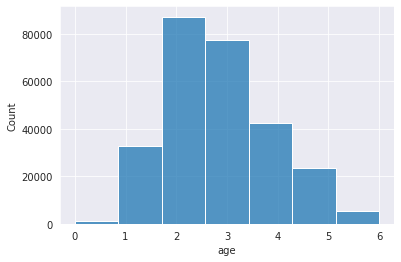

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7)

In [ ]:
df_trn = df_trn.query('age > 0')

In [ ]:
# разбивка данных на train и test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

## LGBM

In [ ]:
def objective_lgbm(trial, X, y, N_FOLDS, random_state):

    lgbm_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [2500]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.035275015373286644]),
        # 'num_leaves': trial.suggest_categorical("num_leaves", [900]),
        # 'max_depth': trial.suggest_categorical("max_depth", [7]),
        # 'min_data_in_leaf': trial.suggest_categorical("min_data_in_leaf", [1200]),
        # 'lambda_l1': trial.suggest_categorical("lambda_l1", [0]),
        # 'lambda_l2': trial.suggest_categorical("lambda_l2", [9]),
        # 'min_split_gain': trial.suggest_categorical("min_split_gain", [3]),
        # 'bagging_fraction': trial.suggest_categorical("bagging_fraction", [0.6909275901887844]),
        # 'bagging_freq': trial.suggest_categorical("bagging_freq", [1]),
        # 'feature_fraction': trial.suggest_categorical("feature_fraction", [0.34716278523119637]),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 100, 50000, step=100),
        "reg_alpha":
        trial.suggest_int("reg_alpha", 0, 100),
        "reg_lambda":
        trial.suggest_int("reg_lambda", 0, 100),
        "min_split_gain":
        trial.suggest_int("min_split_gain", 0, 20),
        "subsample":
        trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "num_classes":
        trial.suggest_categorical("num_classes", [6]),
        "objective":
        trial.suggest_categorical("objective", ["multiclass"]),
        "class_weight":
        trial.suggest_categorical("class_weight", ["balanced"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc_mu")

        model = LGBMClassifier(**lgbm_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc_mu",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        preds_proba = model.predict_proba(X_test)
        cv_predicts[idx] = m.roc_auc_score(y_test,
                                           preds_proba,
                                           multi_class='ovo')

        return np.mean(cv_predicts)

In [ ]:
study_lgbm = optuna.create_study(direction='maximize', study_name='LGBM_01')


def func(trial):
    return objective_lgbm(trial,
                          X_train,
                          y_train,
                          N_FOLDS=N_FOLDS,
                          random_state=RAND)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(func, n_trials=10, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=73, reg_alpha=0.0 will be ignored. Current value: lambda_l1=73
[LightGBM] [Warning] bagging_fraction is set=0.24644454301930213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24644454301930213
[LightGBM] [Warning] feature_fraction is set=0.2520408823309632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2520408823309632
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l1=28
[LightGBM] [Warning] bagging_fraction is set=0.21281491315948664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21281491315948664
[LightGBM]

In [ ]:
study_lgbm.best_params

{'n_estimators': 2500,
 'learning_rate': 0.035275015373286644,
 'num_leaves': 1280,
 'max_depth': 3,
 'min_data_in_leaf': 3200,
 'lambda_l1': 11,
 'lambda_l2': 77,
 'min_split_gain': 15,
 'bagging_fraction': 0.5293493678270612,
 'bagging_freq': 1,
 'feature_fraction': 0.4521381101269853,
 'num_classes': 6,
 'objective': 'multiclass',
 'class_weight': 'balanced',
 'random_state': 42}

In [ ]:
%%time
lgbm_age = LGBMClassifier(**study_lgbm.best_params)
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

In [ ]:
check_overfitting_multiclass(lgbm_age, X_train, y_train_bin, X_test,
                             y_test_bin)

ROC-AUC train = 0.779
ROC-AUC test = 0.755
delta = 3.18%


In [ ]:
print(
    m.classification_report(
        y_test,
        lgbm_age.predict(X_test),
        target_names=['18-25', '25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

       18-25       0.36      0.70      0.47      6528
       25-34       0.50      0.33      0.39     17454
       35-44       0.44      0.24      0.31     15497
       45-54       0.28      0.24      0.26      8489
       55-65       0.22      0.36      0.27      4716
         65+       0.08      0.45      0.14      1101

    accuracy                           0.34     53785
   macro avg       0.31      0.39      0.31     53785
weighted avg       0.40      0.34      0.34     53785



In [ ]:
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)
metrics_age = metrics_age[:5]

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='LGBM_Baseline_Optuna',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
1,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299
2,RandomForest_Baseline,0.630193,0.345829,0.219442,0.345829,0.180165,0.345829,0.170520,1.794659
3,LGBM_Baseline_embeddings,0.764762,0.344662,0.274598,0.344662,0.339979,0.344662,0.275853,1.508385
4,CatBoost_Baseline_embeddings,0.789473,0.444547,0.351707,0.444547,0.272629,0.444547,0.282677,1.300392
0,LGBM_Baseline_Optuna,0.755059,0.338291,0.311993,0.338291,0.386388,0.338291,0.307785,1.472128


## Catboost

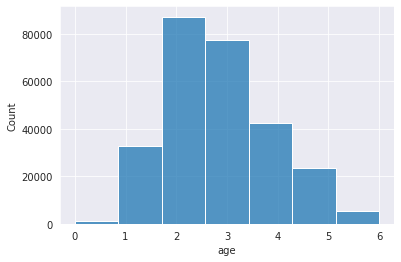

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7)

In [ ]:
df_trn = df_trn.query('age > 0')

In [ ]:
# разбивка данных на train и test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

In [ ]:
from catboost import Pool


def objective_cat(trial, X, y, N_FOLDS, random_state):

    cat_params = {
        # "iterations": trial.suggest_categorical("iterations", [i for i in range(500, 3101, 100)]),
        # "learning_rate": trial.suggest_float("learning_rate",
        #                                      0.001,
        #                                      0.3,
        #                                      log=True),
        "iterations":
        trial.suggest_categorical("iterations", [2600]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.04580986967296549]),
        "max_depth":
        trial.suggest_int("max_depth", 4, 10),
        "colsample_bylevel":
        trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "l2_leaf_reg":
        trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        "random_strength":
        trial.suggest_uniform('random_strength', 10, 50),
        "bootstrap_type":
        trial.suggest_categorical("bootstrap_type",
                                  ["Bayesian", "Bernoulli", "MVS", "No"]),
        "border_count":
        trial.suggest_categorical('border_count', [128, 254]),
        "grow_policy":
        trial.suggest_categorical('grow_policy',
                                  ["SymmetricTree", "Depthwise", "Lossguide"]),
        "od_wait":
        trial.suggest_int('od_wait', 500, 2000),
        "leaf_estimation_iterations":
        trial.suggest_int('leaf_estimation_iterations', 1, 15),
        "random_state":
        trial.suggest_categorical("random_state", [random_state])
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample",
                                                      0.1,
                                                      1,
                                                      log=True)

    cv = StratifiedKFold(n_splits=N_FOLDS,
                         shuffle=True,
                         random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)

        model = CatBoostClassifier(**cat_params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds_proba = model.predict_proba(X_test)
        cv_predicts[idx] = m.roc_auc_score(y_test,
                                           preds_proba,
                                           multi_class='ovo')

        return np.mean(cv_predicts)

In [ ]:
%%time
study_cat = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_01")


def func(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)


study_cat.optimize(func, n_trials=10, show_progress_bar=True)

[I 2023-03-27 06:52:45,011] A new study created in memory with name: Cat_01


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-27 07:45:01,762] Trial 0 finished with value: 0.15248433893291924 and parameters: {'iterations': 2600, 'learning_rate': 0.04580986967296549, 'max_depth': 8, 'colsample_bylevel': 0.9203709920711644, 'l2_leaf_reg': 55.01141456996415, 'random_strength': 30.219239919339135, 'bootstrap_type': 'No', 'border_count': 128, 'grow_policy': 'Depthwise', 'od_wait': 741, 'leaf_estimation_iterations': 11, 'random_state': 42}. Best is trial 0 with value: 0.15248433893291924.
[I 2023-03-27 07:46:52,364] Trial 1 finished with value: 0.1 and parameters: {'iterations': 2600, 'learning_rate': 0.04580986967296549, 'max_depth': 6, 'colsample_bylevel': 0.6925156750752623, 'l2_leaf_reg': 83.95289455446628, 'random_strength': 20.004398809770827, 'bootstrap_type': 'Bayesian', 'border_count': 254, 'grow_policy': 'Lossguide', 'od_wait': 551, 'leaf_estimation_iterations': 10, 'random_state': 42, 'bagging_temperature': 96.8113103460146}. Best is trial 0 with value: 0.15248433893291924.
[I 2023-03-27 09:24

In [ ]:
study_cat.best_params

{'iterations': 2600,
 'learning_rate': 0.04580986967296549,
 'max_depth': 7,
 'colsample_bylevel': 0.6502841606511838,
 'l2_leaf_reg': 93.87518619376878,
 'random_strength': 38.67772771530471,
 'bootstrap_type': 'Bernoulli',
 'border_count': 128,
 'grow_policy': 'SymmetricTree',
 'od_wait': 846,
 'leaf_estimation_iterations': 4,
 'random_state': 42,
 'subsample': 0.7265555309408829}

In [ ]:
cat_params_best = {
    'iterations': 2600,
    'learning_rate': 0.04580986967296549,
    'random_state': 42
}

In [ ]:
%%time
cat_age = CatBoostClassifier(**study_cat.best_params)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

CPU times: user 3h 4min 13s, sys: 35.6 s, total: 3h 4min 49s
Wall time: 51min 26s


In [ ]:
check_overfitting_multiclass(cat_age, X_train, y_train_bin, X_test, y_test_bin)

ROC-AUC train = 0.875
ROC-AUC test = 0.783
delta = 11.66%


In [ ]:
print(
    m.classification_report(
        y_test,
        cat_age.predict(X_test),
        target_names=['18-25', '25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

       18-25       0.55      0.32      0.41      6528
       25-34       0.49      0.63      0.55     17454
       35-44       0.41      0.53      0.46     15497
       45-54       0.39      0.23      0.29      8489
       55-65       0.41      0.20      0.27      4716
         65+       0.43      0.02      0.03      1101

    accuracy                           0.45     53785
   macro avg       0.45      0.32      0.34     53785
weighted avg       0.45      0.45      0.43     53785



In [ ]:
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)
metrics_age = metrics_age[:5]
metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Optuna',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
1,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299
2,RandomForest_Baseline,0.630193,0.345829,0.219442,0.345829,0.180165,0.345829,0.170520,1.794659
3,LGBM_Baseline_embeddings,0.764762,0.344662,0.274598,0.344662,0.339979,0.344662,0.275853,1.508385
4,CatBoost_Baseline_embeddings,0.789473,0.444547,0.351707,0.444547,0.272629,0.444547,0.282677,1.300392
0,CatBoost_Optuna,0.783155,0.450497,0.442351,0.450497,0.321268,0.450497,0.335048,1.276210


Вывод: самые высокие метрики у catboost с эмбеддингами

In [ ]:
metrics_age.to_csv('metrics/metrics_age_tuned.csv', index=False)

# Submission

## Gender

In [ ]:
cat_gender_best = {
    'iterations': 3000,
    'learning_rate': 0.051418504137325544,
    'max_depth': 4,
    'colsample_bylevel': 0.7594434568905333,
    'l2_leaf_reg': 57.13098420673366,
    'random_strength': 30.89358906898957,
    'bootstrap_type': 'No',
    'border_count': 128,
    'grow_policy': 'Lossguide',
    'od_wait': 1886,
    'leaf_estimation_iterations': 15,
    'eval_metric': 'AUC',
    'scale_pos_weight': 0.9531740695036613,
    'random_state': 42
}

In [ ]:
df_train_cat = targets.merge(df, how='inner', on=['user_id']) \
                      .merge(url_emb, how='inner', on='user_id') \
                      .merge(city_emb, how='inner', on=['user_id']) \
                      .merge(reg_emb, how='inner', on=['user_id']) \
                      .merge(model_emb, how='inner', on=['user_id'])

df_train_cat = df_train_cat[df_train_cat['is_male'] != 'NA']
df_train_cat = df_train_cat.dropna()
df_train_cat['is_male'] = df_train_cat['is_male'].map(int)
df_train_cat['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
id_to_sub_data = id_to_submit.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(city_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(model_emb, how='inner', on=['user_id']) \
    .drop('user_id', axis=1)

In [ ]:
%%time
X_train = df_train_cat.drop(['user_id', 'age', 'is_male'], axis=1)
y_train = df_train_cat['is_male']

X_test = id_to_sub_data

# значение для scale_pos_weight
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

CPU times: user 87.4 ms, sys: 123 ms, total: 210 ms
Wall time: 210 ms


In [ ]:
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

cat_features = X_train.select_dtypes('category').columns.tolist()

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_gender_best)

    model.fit(X_train_, y_train_, verbose=False)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)[:, 1]
    cv_predicts_val[idx] = m.roc_auc_score(y_val_, preds_val_proba)

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.8473140732028428 

id = 1 0.8489847350187312 

id = 2 0.8430018692300713 

id = 3 0.8493735341517681 

id = 4 0.8462049992990305 

0.8469758421804888


In [ ]:
# находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

In [ ]:
id_to_submit['is_male'] = test_pred_proba[:, 1]
id_to_submit

,user_id,is_male
221301,221301,0.969222
31271,31271,0.531237
211594,211594,0.564567
253119,253119,0.516738
192578,192578,0.802211
...,...,...
145307,415284,0.541976
145308,415285,0.652584
145309,415286,0.603176
145312,415306,0.649970


## Age

In [ ]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

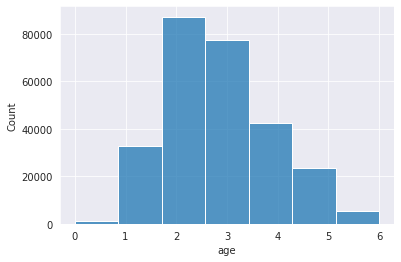

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7)

In [ ]:
df_trn = df_trn.query('age > 0')

In [ ]:
id_to_sub_data = id_to_submit.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(city_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(model_emb, how='inner', on=['user_id']) \
    .drop('user_id', axis=1)

In [ ]:
%%time
X_train = df_trn.drop(['user_id', 'age', 'is_male'], axis=1)
y_train = df_trn['age']

X_test = id_to_sub_data

CPU times: user 134 ms, sys: 129 ms, total: 264 ms
Wall time: 265 ms


In [ ]:
cat_age_params = {
    'iterations': 2600,
    'learning_rate': 0.04580986967296549,
    'max_depth': 7,
    'colsample_bylevel': 0.6502841606511838,
    'l2_leaf_reg': 93.87518619376878,
    'random_strength': 38.67772771530471,
    'bootstrap_type': 'Bernoulli',
    'border_count': 128,
    'grow_policy': 'SymmetricTree',
    'od_wait': 846,
    'leaf_estimation_iterations': 4,
    'random_state': 42,
    'subsample': 0.7265555309408829
}

In [ ]:
finish_test_preds = []
finish_test_preds_proba = []

cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts_val = np.empty(N_FOLDS)

cat_features = X_train.select_dtypes('category').columns.tolist()

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = CatBoostClassifier(cat_features=cat_features, **cat_age_params)

    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val_, y_val_)],
              early_stopping_rounds=100,
              verbose=0)

    # OOF
    preds_val_proba = model.predict_proba(X_val_)
    cv_predicts_val[idx] = m.roc_auc_score(y_val_,
                                           preds_val_proba,
                                           multi_class='ovo')

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    print(f"id = {idx}", cv_predicts_val[idx], '\n')

print(np.mean(cv_predicts_val))

id = 0 0.7700369031021982 

id = 1 0.7700856722776952 

id = 2 0.7695656046299223 

id = 3 0.7695729190339798 

id = 4 0.7688620634266969 

0.7696246324940985


In [ ]:
# находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]

In [ ]:
id_to_submit = pd.read_csv('submissions/submission_gender.csv')

In [ ]:
id_to_submit['age'] = test_pred
id_to_submit

,user_id,is_male,age
0,221301,0.969222,2
1,31271,0.531237,3
2,211594,0.564567,2
3,253119,0.516738,2
4,192578,0.802211,2
...,...,...,...
144719,415284,0.541976,2
144720,415285,0.652584,2
144721,415286,0.603176,3
144722,415306,0.649970,2


In [ ]:
import datetime

cur_time = str(datetime.datetime.now()).replace(' ', '_')[:16]
sub_name = 'submissions/submission_' + cur_time + '.csv'
id_to_submit.to_csv(sub_name, index=False)

Leaderboard score: 1,5629284013